# Allsky CRE vs. cloud type as vertically stacked plots (only set 2, low clouds)

We plot the overcast CRE vs. cloud type. 

## Load Standard and User Libraries

In [1]:
%matplotlib inline

import os, sys, copy, glob
import numpy as np
import datetime
import seaborn as sns
import pylab as pl

In [2]:
pl.rcParams['figure.figsize'] = (16.0, 8.0)
pl.rcParams['font.size'] = 18.0
pl.rcParams['lines.linewidth'] = 3
import xarray as xr

In [3]:
import nawdex_analysis.analysis.ave_cre
import nawdex_analysis.io.collector
import nawdex_analysis.io.selector


import nawdex_analysis.plot.stacked_analysis_plots
reload( nawdex_analysis.plot.stacked_analysis_plots)

from nawdex_analysis.plot.stacked_analysis_plots import vert_stacked_exp_plot, get_exp_kws, get_plotting_order

## Read Radiation Fluxes

This is a slight jump forward in time. Now, average radiation fluxes are available for different CT categories.

In [4]:
#rset= nawdex_analysis.io.collector.get_radflux4set( 'all', method = 'strict' )
#rset= nawdex_analysis.io.collector.get_radflux4set( 'all', method = 'all' )
rset = nawdex_analysis.io.collector.get_radflux4set( 2 )


In [5]:
nawdex_analysis.io.selector.extra_experiments( 2 ) #gather_simset( 2 )

['nawdexnwp-2km-mis-0001-shcon', 'nawdexnwp-2km-mis-0002-shcon']

## Convert Flux to CRE (Scaling !!!!)

In [6]:
nawdex_analysis.analysis.ave_cre.radflux2cre( rset, scaling = True, new_factor = 0.88, old_factor = 0.9 )

In [7]:
rset

<xarray.Dataset>
Dimensions:          (ct: 11, idname: 22, time: 72)
Coordinates:
  * idname           (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'
  * time             (time) datetime64[ns] 2016-09-23 ... 2016-09-25T23:00:00
  * ct               (ct) |S18 'clear_ocean' 'very low' ... 'fractional'
Data variables:
    afrac            (time, ct, idname) float64 29.5 19.69 28.45 ... 7.286 7.286
    swf_up_clear     (idname, time, ct) float64 0.0 0.0 0.0 0.0 ... 0.0 nan 0.0
    swf_net_clear    (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    swf_down         (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lwf_clear        (time, ct, idname) float64 279.0 277.8 ... 273.1 271.1
    swf_up           (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    swf_net          (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lwf              (time, ct, idname) float64 277.8 276.9 ... 257.0 257.0
    expname          (idname) object 'nawde

In [8]:
rset.idname

<xarray.DataArray 'idname' (idname: 22)>
array(['10km_oneMom_Conv', '10km_oneMom_noConv', '10km_twoMom_Conv',
       '10km_twoMom_noConv', '20km_oneMom_Conv', '20km_twoMom_Conv',
       '2km_oneMom_Conv', '2km_oneMom_noConv', '2km_oneMom_shConv',
       '2km_twoMom_Conv', '2km_twoMom_noConv', '2km_twoMom_shConv',
       '40km_oneMom_Conv', '40km_twoMom_Conv', '5km_oneMom_Conv',
       '5km_oneMom_noConv', '5km_twoMom_Conv', '5km_twoMom_noConv',
       '80km_oneMom_Conv', '80km_twoMom_Conv', 'msevi-not_scaled',
       'msevi-scaled'], dtype=object)
Coordinates:
  * idname   (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'

## Adding fractional and vary low clouds

In [9]:
cset = rset.sel(ct = 'very low') + rset.sel(ct = 'fractional')
cset = cset.expand_dims('ct')
cset['ct'] = ['very low / fractional']

In [10]:
cset = xr.concat( [cset, rset], dim = 'ct' )

## all NaNs should be zero of the fraction-weighted radflux contribution

The problems with the NaNs is that the average values and std of shortwave fluxes change strongly if some NaNs mask out a certain time at the day.

In [11]:
mask = cset.notnull()
cset = cset.where( mask, 0)

## Calculate Mean and STD

In [12]:
catlist = list( cset.ct.data )

remove_list = ['clear_ocean', 'semi. above', 'very low', 'fractional']
remove_list += ['high opaque', 'very high opaque', 'semi. thin', 'semi. meanly thick', 'semi. thick']

for rm_cat in remove_list:
    catlist.remove(rm_cat)


idlist = list( cset.idname.data )
idlist.remove( 'msevi-not_scaled' )

dset = cset.sel(ct = catlist, idname = idlist)
daily_mean = dset.groupby('time.day').mean('time')
# dvar = daily_mean.quantile([0.25, 0.5, 0.75], dim = 'day').diff('quantile')
dvar = daily_mean.std('day')
mvar = dset.mean('time')

In [13]:
mvar

<xarray.Dataset>
Dimensions:          (ct: 3, idname: 21)
Coordinates:
  * idname           (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'
  * ct               (ct) object 'very low / fractional' 'low' 'middle'
Data variables:
    afrac            (ct, idname) float64 29.12 33.77 30.1 ... 4.262 4.942 5.305
    swf_up_clear     (ct, idname) float64 79.14 79.36 79.27 ... 36.71 33.06
    swf_net_clear    (ct, idname) float64 -532.4 -534.9 -536.2 ... -218.0 -225.9
    swf_down         (ct, idname) float64 -611.5 -614.3 -615.5 ... -254.7 -258.9
    lwf_clear        (ct, idname) float64 545.5 545.3 546.8 ... 253.6 251.8
    swf_up           (ct, idname) float64 114.6 178.8 112.5 ... 133.9 130.2
    swf_net          (ct, idname) float64 -496.9 -435.5 -503.0 ... -120.9 -128.7
    lwf              (ct, idname) float64 531.6 521.8 533.1 ... 220.0 208.5
    fnet             (ct, idname) float64 34.71 86.25 30.08 ... 99.17 79.81
    fnet_clear       (ct, idname) float64 13.05 10.37 10.55 ..

In [14]:
mvar.idname.data

array(['10km_oneMom_Conv', '10km_oneMom_noConv', '10km_twoMom_Conv',
       '10km_twoMom_noConv', '20km_oneMom_Conv', '20km_twoMom_Conv',
       '2km_oneMom_Conv', '2km_oneMom_noConv', '2km_oneMom_shConv',
       '2km_twoMom_Conv', '2km_twoMom_noConv', '2km_twoMom_shConv',
       '40km_oneMom_Conv', '40km_twoMom_Conv', '5km_oneMom_Conv',
       '5km_oneMom_noConv', '5km_twoMom_Conv', '5km_twoMom_noConv',
       '80km_oneMom_Conv', '80km_twoMom_Conv', 'msevi-scaled'],
      dtype=object)

## Plotting

In [19]:
from nawdex_analysis.plot.legend import legend_renamer, plegend

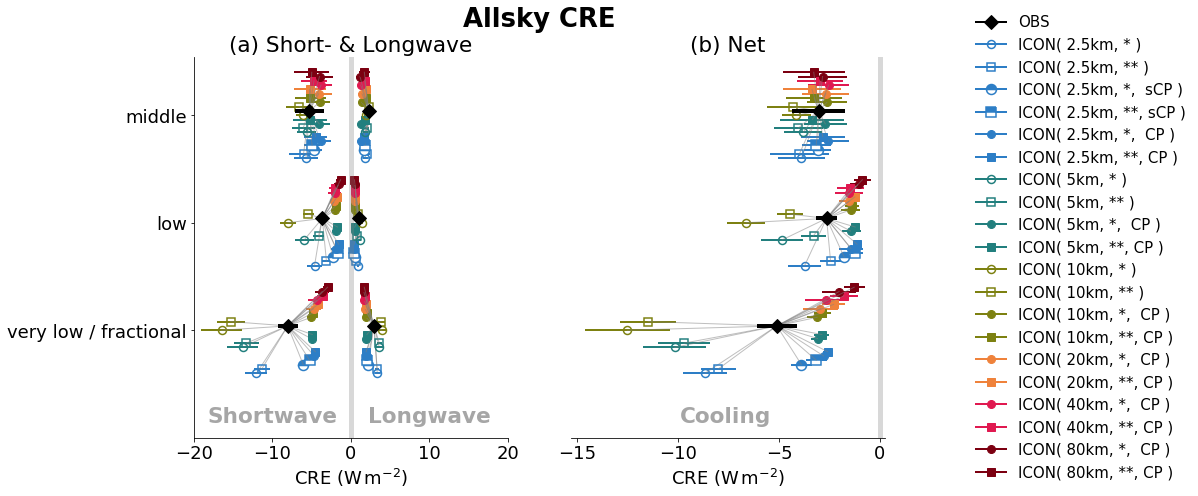

In [20]:
doffset = 0.04

fig, ax = pl.subplots( ncols = 2, figsize = (24, 7), )

pl.sca(ax[0])
vert_stacked_exp_plot( mvar, 'scre_contrib' , var_err = dvar, doffset = doffset)
vert_stacked_exp_plot( mvar, 'lcre_contrib' , var_err = dvar, doffset = doffset)

xlim = pl.xlim(-20, 20)
pl.text( xlim[0] / 2, -0.8, 'Shortwave', 
            color = 'gray', ha = 'center', va = 'center', alpha = 0.7, 
            fontweight = 'bold', fontsize = 'large')

pl.text( xlim[1] / 2, -0.8, 'Longwave', 
            color = 'gray', ha = 'center', va = 'center', alpha = 0.7, 
            fontweight = 'bold', fontsize = 'large')

sns.despine(ax = ax[0])
pl.title('(a) Short- & Longwave')


pl.sca(ax[1])
vert_stacked_exp_plot( mvar, 'net_cre_contrib' , var_err = dvar, doffset = doffset)
sns.despine(left = True, ax = ax[1])
pl.title('(b) Net')
pl.yticks([])
xlim = pl.xlim()

pl.text( xlim[0] / 2, -0.8, 'Cooling', 
            color = 'gray', ha = 'center', va = 'center', alpha = 0.7, 
            fontweight = 'bold', fontsize = 'large')

#pl.text( xlim[1] * 0.8, -0.8, 'Warming', 
#            color = 'gray', ha = 'center', va = 'center', alpha = 0.7, 
#            fontweight = 'bold', fontsize = 'large')

#plegend()

for a in ax:
    a.axvline(0, color = 'gray', lw = 5, alpha = 0.3)
    a.set_xlabel('CRE ($\mathrm{W\, m^{-2}}$)')
    a.set_ylim(-1,None)

pl.suptitle('Allsky CRE', fontsize = 'x-large', fontweight = 'bold')

pl.subplots_adjust( left = 0.3, right = 0.7 )
plegend( bbox_to_anchor=(2., 0.5))
pl.savefig( '../pics/01-BT108-overview-2km.png', dpi = 300,)


## Plot CRE biases

In [19]:
daily_bias = daily_mean - daily_mean.sel(idname = 'msevi-scaled')


idlist = list( daily_bias.idname.data )
idlist.remove('msevi-scaled')

daily_bias = daily_bias.sel(idname = idlist)

mbias = daily_bias.mean('day')
dbias = daily_bias.std('day')


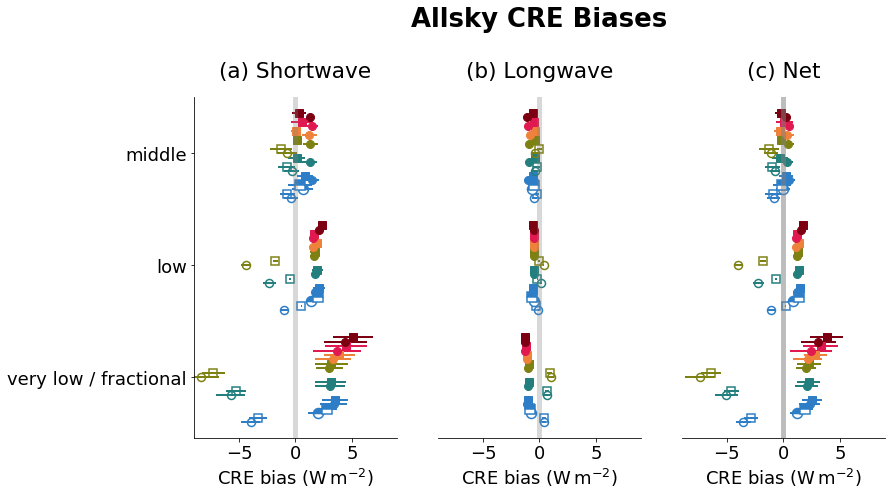

In [21]:
doffset = 0.04

fig, ax = pl.subplots( ncols = 3,  figsize = (24, 7), )

pl.sca(ax[0])
vert_stacked_exp_plot( mbias, 'scre_contrib' , 
                       var_err = dbias, doffset = doffset, 
                       connect2obs = False, obsref_name = '2km_oneMom_noConv')
sns.despine(ax = ax[0])
pl.title('(a) Shortwave', pad = 20)

pl.sca(ax[1])
vert_stacked_exp_plot( mbias, 'lcre_contrib' , 
                       var_err = dbias, doffset = doffset, 
                       connect2obs = False, obsref_name = '2km_oneMom_noConv')
pl.yticks([])
pl.title('(b) Longwave', pad = 20)

pl.sca(ax[2])
vert_stacked_exp_plot( mbias, 'net_cre_contrib' , 
                       var_err = dbias, doffset = doffset, 
                       connect2obs = False, obsref_name = '2km_oneMom_noConv')
pl.yticks([])
pl.title('(c) Net', pad = 20)

pl.suptitle('Allsky CRE Biases', fontsize = 'x-large', fontweight = 'bold')
for a in ax:
    a.set_xlim(-9,9)
    a.axvline(0, color = 'gray', lw = 5, alpha = 0.3)
    a.set_xlabel('CRE bias ($\mathrm{W\, m^{-2}}$)')
    
for a in ax[1:]:
    sns.despine(left = True, ax = a)
    
pl.axvline(0, color = 'gray', lw = 5, alpha = 0.3)
pl.subplots_adjust( left = 0.3, right = 0.7, top = 0.8 )
pl.savefig( '../pics/cre-allsky_bias-vs-ct_shallowclouds_set2.png', dpi = 300,)
